# Population firing rate
### 1. Overview

In recent experiments, people are able to manipulate *Dictyostelium*  population firing rate by changing two cell-cell coupling parameters- population density and extracellular fluid flow rate/ $cAMP_{e}$ dilution rate. In this notebook we are going to explore how different model tunes population firing rate with different densities and dilution rates  cells (below).

Because it is computationally costly to reproduce the full and high resolution heatmap for each model, this notebook offers two options for readers to play with different models.

1) Define a set of parameter pairs (density, dilution rate) of interest  and visualize simulation traces of population-wide dynamics. 

2) Reproduce a heat map with lower resolution. For example,define a parameter set with size 5 x 5 and visualize the heatmap. Note that the full simulation for a model could cost up to 2 hours on a 36-core computing node with parallel computing. 
 
![Population firing rate](imgs/population_firing_rate.png)
<h5><center>Population firing rate.</center></h5>

#### Let's start by importing packages and setting up time scaling parameters

In [1]:
import os
import numpy as np
from time import perf_counter 
from scipy.signal import find_peaks
import math
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'Arial'}
matplotlib.rc('font', **font)
import scipy.io
import pandas as pd

os.chdir("../compare_models")
from Goldbeter1987_agent_and_pop_FUN import Goldbeter1987_pop_3var_SCnoise
from MaedaLoomis2004_agent_and_pop_FUN import MaedaLoomis2004_pop_SCnoise
from Gregor2010_agent_and_pop_FUN import Gregor2010_pop
from Sgro2015_agent_and_pop_FUN import Sgro2015_pop
from Kamino2017_agent_and_pop_FUN import Kamino2017_pop_SCnoise
from NB_pop_functions import * 

from NB_pop_functions import plot_POP_oscillation_FR
#Normalization parameters
from Params import NormParams
for key,val in NormParams.items():
        exec(key + '=val')
os.chdir("../Notebooks") 


### 2. Experimental data 
#### import and plot experimental data
from [Sgro et al. 2015](https://www.embopress.org/doi/full/10.15252/msb.20145352)

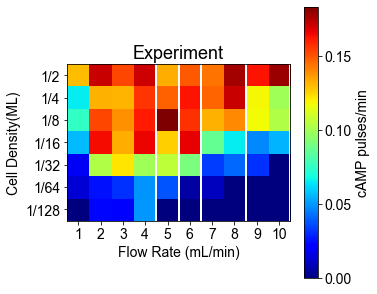

In [2]:
npzfile = np.load('../exp_data/Gregor2010_pop_firing_rate.npz')
PopRateExp = npzfile['PopRateExp']
JExp = npzfile['JExp']; RhoExp = npzfile['RhoExp']

fig3 = plt.figure(figsize=(5, 5))
grid = plt.GridSpec(1,1, wspace=0.5, hspace=0.4)

ax0= fig3.add_subplot(grid[0,0])
ax0.set_xticks([0,1,2,3,4,5,6,7,8,9]); 
ax0.set_xticklabels([1,2,3,4,5,6,7,8,9,10],fontsize=14)
ax0.set_yticks([0,1,2,3,4,5,6,7]); 
ax0.set_yticklabels(['1/2','1/4','1/8','1/16','1/32','1/64','1/128'],fontsize=14)
ax0.set_title('Experiment', fontdict={'fontsize': 18, 'fontweight': 'medium'})
ax0.set_xlabel('Flow Rate (mL/min)', size=14)
ax0.set_ylabel('Cell Density(ML)', size=14)
heatmap = ax0.imshow(PopRateExp, cmap='jet') # cmap='jet'
x=[3.5,4.5,5.5,7.5,9.5]
[ax0.axvline(_x, color='white',linewidth=2) for _x in x]
# heatmap.set_clim(0,0.16)
cbar=fig3.colorbar(heatmap, ax=ax0,ticks=[0,0.05,0.1,0.15]);
cbar.ax.tick_params(labelsize = 14) 
cbar.set_label( 'cAMP pulses/min',size=14)

### 3. Receptor desensitization
#### Set up parameters (from Table II in [Matiel & Goldbeter 1986](https://www.sciencedirect.com/science/article/pii/S0006349587832757?via%3Dihub) )

In [3]:
os.chdir("../compare_models") 
from NB_pop_functions import Goldbeter_pop
from Params import Goldbeter3PopParam
os.chdir("../Notebooks")

sigma = 10 # noise strength
N = 100 # number of cells in the population
dt=0.001; t_tot=30; t=list(np.arange(0,t_tot*Nt_Goldbeter,dt))
nSteps = len(t)

#### Define population density and dilution/flow rate, and get population $cAMP_i$ simulation response

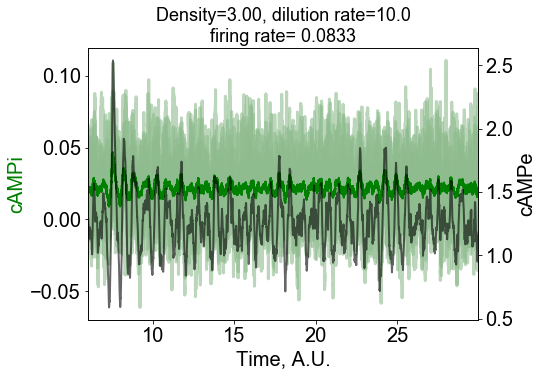

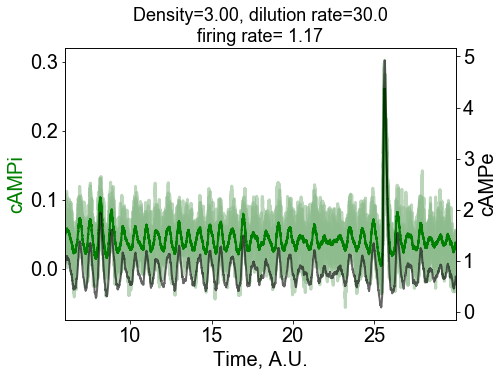

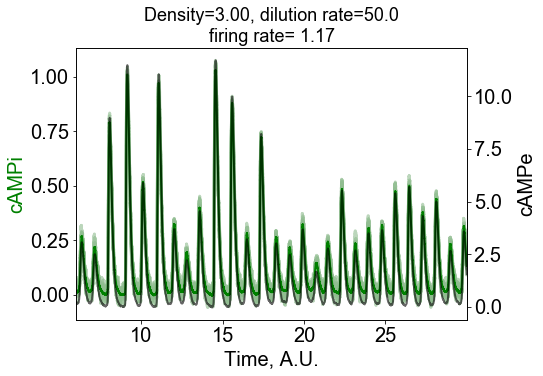

In [4]:
# cAMPe influx level. Default as 0. 
campExt_influx_trace=np.zeros(len(t))
cAMPext_influx = 0; cAMPext_influx_trace = np.ones(nSteps)*cAMPext_influx

# Define dilution/flow rate array
kc_arr = np.array([10,30,50]) # ([25])
# Define population density array
one_over_h_arr = np.array([3]) # ([0.3,1,3])# cell density 
h_arr = 1/one_over_h_arr 

if_plt_traces = True # whether to plot individuial traces

for kc_temp in kc_arr:
    Goldbeter3PopParam['kc'] = kc_temp
    for h_temp in h_arr:
        Goldbeter3PopParam['h'] =  h_temp
        # Initializations
        p0=0.8*np.ones(N); a0=3; b0=0.9*np.ones(N); g0=0
        p_trace=np.zeros((N,nSteps));p_trace[:,0] = p0; 
        b_trace=np.zeros((N,nSteps));b_trace[:,0] = b0; 
        g_trace=np.zeros((nSteps,1));g_trace[0] = g0; 

        Goldbeter3_pop= Goldbeter1987_pop_3var_SCnoise(0,p0,b0,g0,Goldbeter3PopParam)

        for i in range(len(t)-1):
            p_next,b_next,g_next= Goldbeter3_pop.update(dt,a0,cAMPext_influx_trace[i]) # cAMPext_influx_trace[i])
            p_trace[:,i+1]= p_next
            b_trace[:,i+1]= b_next
            g_trace[i+1] = g_next
        # normalize
        b_trace_norm = b_trace/Nh_Goldbeter
        b_trace_norm_mean = np.mean(b_trace_norm,axis = 0)
        t_plot_Goldbeter = np.array(t)/Nt_Goldbeter

        later_portion = 0.2 # start count peaks after this X total simulation time
        b_trace_norm_later = b_trace_norm[:,math.floor(nSteps * later_portion):]
        b_trace_norm_mean_later=b_trace_norm_mean[math.floor(nSteps * later_portion):] # the later part of trace
        
        g_trace_later = g_trace[math.floor(nSteps * later_portion):]
        t_plot_Goldbeter_short = t_plot_Goldbeter[math.floor(nSteps * later_portion):] 

        pk_find_thresh = 5/Nh_Goldbeter
        # pk_find_prm = 0.1
        # pop_max = np.amax(b_trace_norm_mean); pop_min = np.amin(b_trace_norm_mean); 
        # PkPos, PkProperties = find_peaks(b_trace_norm_mean_later, prominence = pk_find_prm*(pop_max-pop_min))
        PkPos, PkProperties = find_peaks(b_trace_norm_mean_later, prominence = pk_find_thresh)
                                         
        if len(PkPos) == 0:
            firing_rate = 0;
        else:   
            firing_rate = len(PkPos)/(t_tot*(1-later_portion))
        
        if if_plt_traces:  
            #title = 'Noise=' +str(sigma)+', density='+'{:#.3n}'.format(np.float64(1/h_temp))+\
            #    '\n, dilution rate='+ '{:#.3n}'.format(np.float64(kc_temp))+' firing rate= '+'{:#.3n}'.format(np.float64(firing_rate)) 
            
            title = 'Density='+'{:#.3n}'.format(np.float64(1/h_temp))+\
                ', dilution rate='+ '{:#.3n}'.format(np.float64(kc_temp))+'\nfiring rate= '+'{:#.3n}'.format(np.float64(firing_rate)) 
            
            '''            
            # check finding peaks
            fig = plt.figure()
            plt.plot(b_trace_norm_mean_later)
            plt.plot(PkPos, b_trace_norm_mean_later[PkPos], "x")
            plt.title(title)
            '''
            # plot population mean and selected single cell traces
            SC_traces_idx = [0,2,4,6,8,10]   
            plot_POP_oscillation_FR(title, t_plot_Goldbeter_short,b_trace_norm_mean_later,'cAMPi',
                                    0,0, g_trace_later,[t_plot_Goldbeter_short[0],t_plot_Goldbeter_short[-1]],
                                    b_trace_norm_later, SC_traces_idx )         
            plt.show()
            # plot_POP_oscillation(t_plot_Goldbeter_short,b_trace_norm_mean_later,cAMPext_influx,
            #                      t_tot*(1-later_portion), 0,title, b_trace_norm_later, SC_traces_idx)
    
            

### 4. CDINFB
#### Set up parameters (from supplementary in [Maeda et al. 2004](https://science.sciencemag.org/content/304/5672/875/tab-figures-data) )

In [5]:
os.chdir("../compare_models")
from NB_pop_functions import Maeda_pop
from Params import MaedaPopParam
os.chdir("../Notebooks") 

sigma = 0.1 # noise strength
N = 100 # number of cells in the population
gamma = 0# [cAMP]e flow rate 
rho = 1 # cell density

dt=0.001; t_tot=60; t=list(np.arange(0,t_tot*Nt_Maeda,dt))
nSteps = len(t)

#### Define population density and dilution/flow rate, and get population $cAMP_i$ simulation response

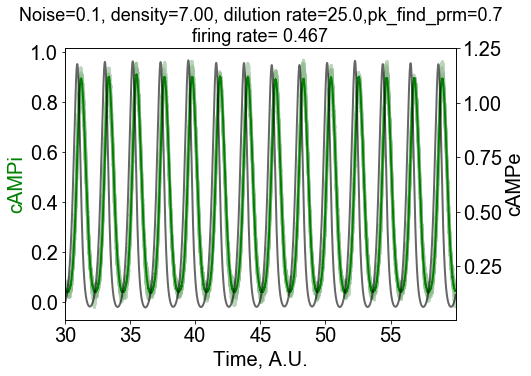

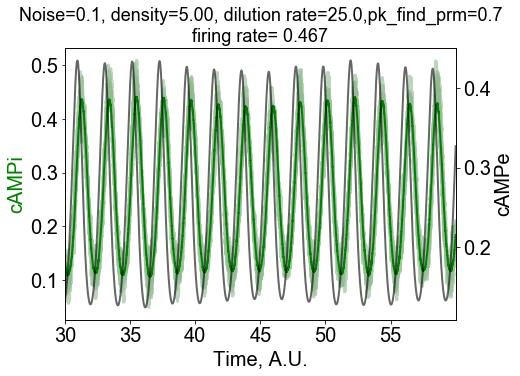

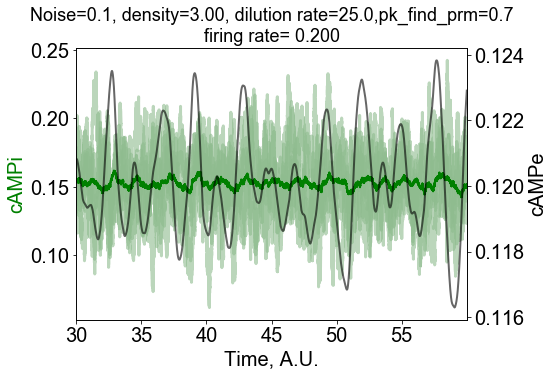

In [6]:
# cAMPe influx level. Default as 0. 
cAMPext_influx_trace=np.zeros(len(t))
cAMPext_influx = 0; cAMPext_influx_trace = np.ones(nSteps)*cAMPext_influx

# Define dilution/flow rate array
gamma_arr=np.array([25]) # ([15,25,35])# 
# Define population density array
rho_arr=np.array([7,5,3])# ([5]) #

if_plt_traces = True # whether to plot individuial traces

for gamma_temp in gamma_arr:
    for rho_temp in rho_arr:
        # Initializations
        ACA0=0.1*np.ones(N); PKA0=0.1*np.ones(N); ERK20=0.1*np.ones(N); 
        RegA0=0.1*np.ones(N); cAMPi0=0.01*np.ones(N); cAMPe0=0.1; CAR10=0.1*np.ones(N)

        ACA_trace=np.zeros((N,nSteps)); ACA_trace[:,0] = ACA0
        PKA_trace=np.zeros((N,nSteps)); PKA_trace[:,0] = PKA0
        ERK2_trace=np.zeros((N,nSteps)); ERK2_trace[:,0] = ERK20
        RegA_trace= np.zeros((N,nSteps)); RegA_trace[:,0] = RegA0
        cAMPi_trace= np.zeros((N,nSteps)); cAMPi_trace[:,0] = cAMPi0
        cAMPe_trace=np.zeros((nSteps,1));cAMPe_trace[0] = cAMPe0;
        CAR1_trace= np.zeros((N,nSteps)); CAR1_trace[:,0] = CAR10

        MaedaLoomis_pop=MaedaLoomis2004_pop_SCnoise([1,1],ACA0,PKA0,ERK20,RegA0,cAMPi0,cAMPe0,CAR10, MaedaPopParam)

        for i in range(len(t)-1):
            ACA_next,PKA_next,ERK2_next,RegA_next,\
            cAMPi_next,cAMPe_next,CAR1_next=MaedaLoomis_pop.update(dt,cAMPext_influx_trace[i],rho_temp,gamma_temp)
            ACA_trace[:,i+1]= ACA_next
            PKA_trace[:,i+1]= PKA_next
            ERK2_trace[:,i+1]= ERK2_next
            RegA_trace[:,i+1]= RegA_next
            cAMPi_trace[:,i+1]= cAMPi_next
            cAMPe_trace[i+1]= cAMPe_next
            CAR1_trace[:,i+1]= CAR1_next


        cAMPi_trace_norm = cAMPi_trace/Nh_Maeda   
        cAMPi_trace_norm_mean = np.mean(cAMPi_trace_norm,axis = 0) # population mean

        later_portion = 0.5 # start count peaks after this X total simulation time
        cAMPi_trace_norm_later = cAMPi_trace_norm[:,math.floor(nSteps * later_portion):]
        cAMPi_trace_norm_mean_later=cAMPi_trace_norm_mean[math.floor(nSteps * later_portion):] # the later part of trace
        
        cAMPe_trace_later = cAMPe_trace[math.floor(nSteps * (1-later_portion)):] 
        t_plot_Maeda = np.array(t)/Nt_Maeda
        t_plot_Maeda_short = t_plot_Maeda[math.floor(nSteps * later_portion):] 

        pop_max = np.amax(cAMPi_trace_norm_mean_later); pop_min = np.amin(cAMPi_trace_norm_mean_later); 
        pk_find_prm = 0.7
        PkPos, PkProperties = find_peaks(cAMPi_trace_norm_mean_later, prominence=((pop_max-pop_min)*pk_find_prm,pop_max))
        
        if len(PkPos) == 0:
            firing_rate = 0; height = 0
        else: 
            firing_rate = len(PkPos)/(t_tot*(1-later_portion))
            height = np.mean(PkProperties["prominences"])
        
        if if_plt_traces:    
            title = 'Noise=' +str(sigma)+', density='+'{:#.3n}'.format(np.float64(rho_temp))+\
            ', dilution rate='+'{:#.3n}'.format(np.float64(gamma_temp))+',pk_find_prm='+str(pk_find_prm)+\
            '\nfiring rate= '+'{:#.3n}'.format(np.float64(firing_rate))
            '''
            # check find_peaks
            fig = plt.figure()
            plt.plot(cAMPi_trace_norm_mean_later)
            plt.plot(PkPos, cAMPi_trace_norm_mean_later[PkPos], "x")
            plt.title(title)
            '''
            # plot population mean and selected single cell traces
            SC_traces_idx = [0,2,4,6,8,10]
            plot_POP_oscillation_FR(title, t_plot_Maeda_short,cAMPi_trace_norm_mean_later,'cAMPi',
                            0,0, cAMPe_trace_later,[t_plot_Maeda_short[0],t_plot_Maeda_short[-1]],  cAMPi_trace_norm_later, SC_traces_idx )         
            # plot_POP_oscillation(t_plot_Maeda_short,cAMPi_trace_norm_mean_later,cAMPext_influx,
            #                      t_tot*(1-later_portion), 0,title, cAMPi_trace_norm_later, SC_traces_idx)


        


### 5. Phase oscillator
#### Set up parameters

In [7]:
os.chdir("../compare_models")
from NB_pop_functions import Gregor_pop
from Params import GregorPopParam
os.chdir("../Notebooks") 

Amax=20;  Abas=0.4 # uM
Vt = 1 #chamber size ml
Nc=100 # Num of cells
eta = 0.002 # noise strength
rho = 1/12 # cell density, 1/ml
k = 5 #ml/min

dt=0.001; t_tot=25; t=list(np.arange(0,t_tot*Nt_Gregor,dt))
nSteps = len(t)

#### Define population density and dilution/flow rate, and get population $cAMP_i$ simulation response

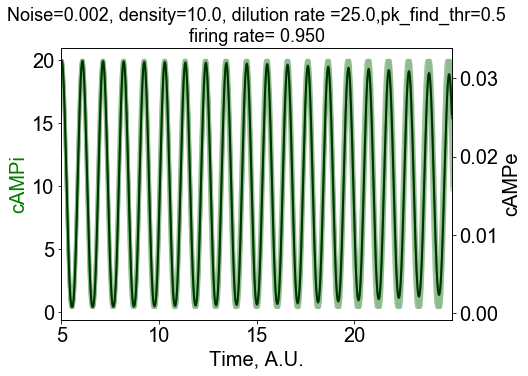

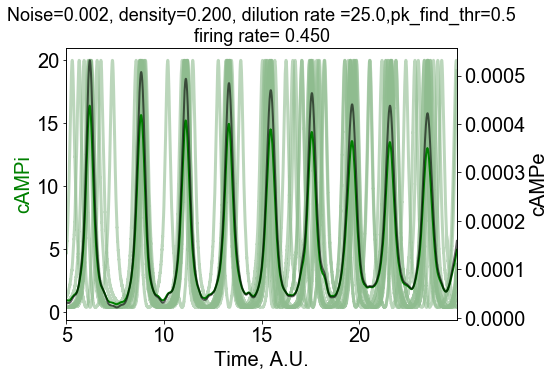

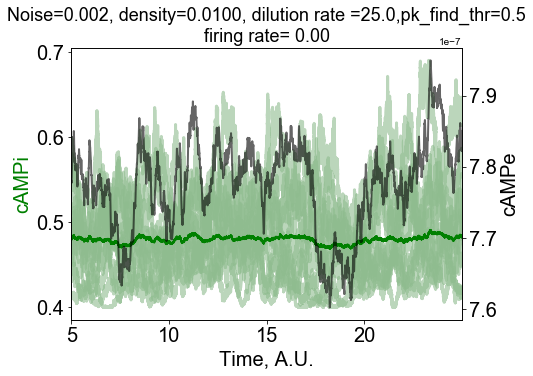

In [8]:
# cAMPe influx level. By default is 0.
cAMPext_influx_trace=np.zeros(len(t))
time_separation = 0

# Define dilution/flow rate array
k_arr=np.array([25]) # ([0.5,25,50,100]) 
# Define population density array
rho_arr=np.array([10,0.2,0.01]) # ([0.2])

if_plt_traces = True # whether to plot individuial traces
SC_traces_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12] # Index of single cell traces to plot 

for k_temp in k_arr:
    GregorPopParam['k'] = k_temp
    for rho_temp in rho_arr:
        GregorPopParam['rho'] = rho_temp
        [t_plot_Gregor,  cAMPi, thetai,cAMPe] = Gregor_pop(GregorPopParam,dt,
                                                           t, cAMPext_influx_trace, time_separation)
        
        t_plot_Gregor = t_plot_Gregor/(Nt_Gregor)
        
        cAMPi_mean= np.mean(cAMPi,axis = 0)
        thetai_mean = np.mean(thetai,axis = 0)

        later_portion = 0.2 # start count peaks after this X total simulation time
        cAMPi_later = cAMPi[:,math.floor(nSteps * later_portion):] 

        cAMPi_mean_later=cAMPi_mean[math.floor(nSteps * later_portion):] 
        # thetai_mean_later=thetai_mean[math.floor(nSteps * later_portion):] 
        # thetai_mean_later_norm = thetai_mean_later/np.amax(thetai_mean_later)

        cAMPe_later=cAMPe[math.floor(nSteps * later_portion):] 

        t_plot_Gregor_later = t_plot_Gregor[math.floor(nSteps * later_portion):]
        
        pk_find_thresh = 0.5
        PkPos, PkProperties = find_peaks(cAMPi_mean_later, prominence = pk_find_thresh)
        if len(PkPos) == 0:
            firing_rate = 0; height = 0
        else: 
            firing_rate = len(PkPos)/(t_tot*(1-later_portion))
            height = np.mean(PkProperties["prominences"])
        
        if if_plt_traces:
            title = 'Noise=' +str(eta)+', density='+'{:#.3n}'.format(np.float64(rho_temp))+\
            ', dilution rate ='+'{:#.3n}'.format(np.float64(k_temp))+',pk_find_thr='+str(pk_find_thresh)+\
            '\nfiring rate= '+'{:#.3n}'.format(np.float64(firing_rate))
            '''
            # check find peaks
            fig = plt.figure()
            plt.plot(cAMPi_mean_later)
            plt.plot(PkPos, cAMPi_mean_later[PkPos], "x")
            plt.title(title)
            '''
            
            # Plot selected traces
            plot_POP_oscillation_FR(title, t_plot_Gregor_later,cAMPi_mean_later,'cAMPi',
                            0,'thetai', cAMPe_later,[t_plot_Gregor_later[0],t_plot_Gregor_later[-1]], 
                                    cAMPi_later, SC_traces_idx )         

### 6. IPNFB
#### Set up parameters
from [Sgro et al. 2015](https://www.embopress.org/doi/full/10.15252/msb.20145352)

In [9]:
os.chdir("../compare_models")
from NB_pop_functions import Sgro_pop
from Params import SgroPopParam
os.chdir("../Notebooks")
N = 100 # number of cells in the population

dt=0.001 ; t_tot=25*Nt_Sgro;t=list(np.arange(0,t_tot,dt))
nSteps = len(t)

#### Define population density and dilution/flow rate, and get population $cAMP_i$ simulation response

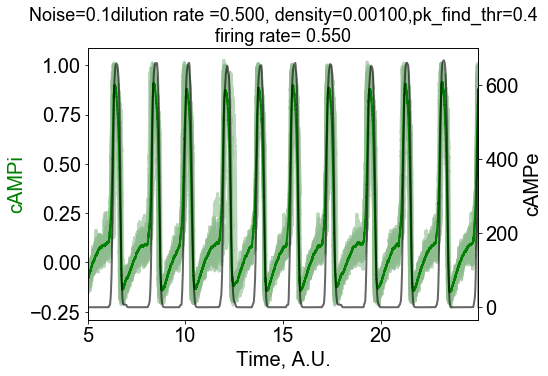

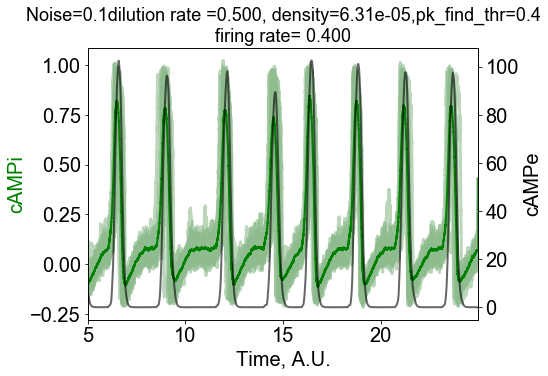

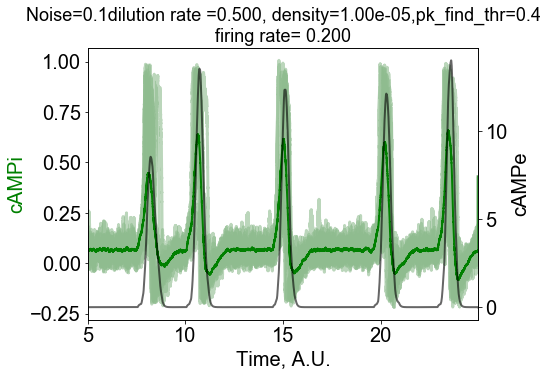

In [10]:
# cAMPe influx level. By default is 0.
cAMPext_influx_trace=np.zeros(len(t))

# Define dilution/flow rate array
j_arr=np.array([0.5]) 
# Define population density array
rho_arr=np.array([10**(-3),10**(-4.2),10**(-5)])

if_plt_traces = True # whether to plot individuial traces
SC_traces_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12] # Index of single cell traces to plot 

for j_temp in j_arr:
    SgroPopParam['j'] = j_temp
    for rho_temp in rho_arr:
        SgroPopParam['rho'] = rho_temp
        [t_plot_Sgro, A_plot,  R_orig, R_plot, cAMPe] = Sgro_pop(SgroPopParam,dt,
                                                              t,cAMPext_influx_trace)
        
        t_plot_Sgro = t_plot_Sgro/(Nt_Sgro)
           
            
        A_plot_mean= np.mean(A_plot,axis = 0)
        R_plot_mean = np.mean(R_plot,axis = 0)

        later_portion = 0.2 # start count peaks after this X total simulation time
        A_plot_later = A_plot[:,math.floor(nSteps * later_portion):] 

        A_plot_mean_later=A_plot_mean[math.floor(nSteps * later_portion):] 

        # R_plot_mean_later=R_plot_mean[math.floor(nSteps * later_portion):] 
        # R_plot_mean_later_norm = R_plot_mean_later/np.amax(R_plot_mean_later)

        cAMPe_later=cAMPe[math.floor(nSteps * later_portion):] 
        t_plot_Sgro_later = t_plot_Sgro[math.floor(nSteps * later_portion):]
        
        pk_find_thresh = 0.4
        PkPos, PkProperties = find_peaks(A_plot_mean_later, prominence = pk_find_thresh )
        if len(PkPos) == 0:
            firing_rate = 0; height = 0
        else: 
            firing_rate = len(PkPos)/(t_tot/Nt_Sgro*(1-later_portion))
            height = np.mean(PkProperties["prominences"])
        
        if if_plt_traces:  
            title = 'Noise=' +str(sigma)+ 'dilution rate ='+'{:#.3n}'.format(np.float64(j_temp))+\
            ', density='+'{:#.3n}'.format(np.float64(rho_temp))+\
            ',pk_find_thr='+str(pk_find_thresh)+\
            '\nfiring rate= '+'{:#.3n}'.format(np.float64(firing_rate))
            
            '''
            # check find peaks
            fig = plt.figure()
            plt.plot(A_plot_mean_later)
            plt.plot(PkPos, A_plot_mean_later[PkPos], "x")
            plt.title(title)
            '''
            
            # Plot selected traces
            plot_POP_oscillation_FR(title, t_plot_Sgro_later,
                                    A_plot_mean_later,'cAMPi',
                                    0,0, cAMPe_later,[t_plot_Sgro_later[0],t_plot_Sgro_later[-1]],
                                    A_plot_later, SC_traces_idx )  

### 7. IFFL
#### Set up parameters

In [11]:
'''tau=1.5; n=2; K=4; kt=2; delta=0.01

gamma=3 # cAMPe dilution/degradation rate 
rho= 1 # population density

sigma = 0.01 # noise strength
N=100 # number of cells in a population

KaminoPopParam={'tau':tau,'n':n,'K':K,'kt':kt,'delta':delta,\
               'gamma':gamma,'rho':rho, 'sigma':sigma, 'N':N }'''
os.chdir("../compare_models")
from NB_pop_functions import Kamino_pop
from Params import KaminoPopParam
os.chdir("../Notebooks")

sigma = 0.0001# noise strength
N=100 # number of cells in a population
KaminoPopParam['sigma'] = sigma; KaminoPopParam['N'] = N;
KaminoPopParam['delta'] = 0.01

dt=0.001; t_tot = 50; t=list(np.arange(0,t_tot*Nt_Kamino,dt))
nSteps = len(t)

#### Define population density and dilution/flow rate, and get population $cAMP_i$ simulation response

In [12]:
# cAMPe influx level. Default is 0. 
cAMPext_influx_trace=np.zeros(len(t))

gamma_arr = np.array([1, 1.5,5, 25])# ([25]) # 
rho_arr = np.array([10]) # np.array([20,15,10]) # ([10])
if_plt_traces = True # whether to plot individuial traces

SC_traces_idx = [0,1,2,3,4,5,6,7,8,9,10,11,12] # Index of single cell traces to plot 

for gamma_temp in gamma_arr:
    KaminoPopParam['gamma'] = gamma_temp
    for rho_temp in rho_arr:
        KaminoPopParam['rho'] = rho_temp
        # Initializations
        x0=0.01*np.ones(N)
        y0=0.08*np.ones(N)
        z0=0
        x_trace=np.zeros((N,nSteps)); x_trace[:,0] = x0
        y_trace=np.zeros((N,nSteps)); y_trace[:,0] = y0
        z_trace=np.zeros((nSteps,1)); z_trace[0] = z0
        Kamino_pop = Kamino2017_pop_SCnoise(x0,y0,z0,KaminoPopParam)

        for i in range(nSteps-1):
            x_next,y_next,z_next=Kamino_pop.update(cAMPe                                       xt_influx_trace[i],dt)
            x_trace[:,i+1] = x_next
            y_trace[:,i+1] = y_next
            z_trace[i+1] = z_next

        later_portion = 0.25 # start count peaks after this X total simulation time
        y_trace_norm =  (y_trace-Nh_Kamino_offset)/Nh_Kamino # height normalization
        y_trace_norm_later=y_trace_norm[:,math.floor(nSteps * later_portion):] # the later part of trace
        y_trace_norm_mean = np.mean(y_trace_norm,axis=0)
        y_trace_norm_mean_later=y_trace_norm_mean[math.floor(nSteps * later_portion):] # the later part of trace
        
        z_trace_later = z_trace[math.floor(nSteps * later_portion):]
        t_plot_Kamino = np.array(t)/Nt_Kamino
        t_plot_Kamino_short = t_plot_Kamino[math.floor(nSteps * later_portion):] 
        
        pk_find_thresh = 0.03
        PkPos, PkProperties = find_peaks(y_trace_norm_mean_later, prominence=pk_find_thresh)
        if len(PkPos) == 0:
            firing_rate = 0; height = 0
        else: 
            firing_rate = len(PkPos)/(t_tot*(1-later_portion))
            height = np.mean(PkProperties["prominences"])
        
        if if_plt_traces:
            title = 'Noise=' +str(sigma)+ 'dilution rate ='+\
            '{:#.3n}'.format(np.float64(gamma_temp))+\
            ', density='+'{:#.3n}'.format(np.float64(rho_temp))+\
            ',pk_find_thr='+str(pk_find_thresh)+\
            '\nfiring rate= '+'{:#.3n}'.format(np.float64(firing_rate))
            '''
            # check find peaks
            fig = plt.figure()
            plt.plot(y_trace_norm_mean_later)
            plt.plot(PkPos, y_trace_norm_mean_later[PkPos], "x")
            plt.title(title)
            '''
            # Plot selected traces
            plot_POP_oscillation_FR(title, t_plot_Kamino_short,
                                    y_trace_norm_mean_later,'cAMPi',
                                    0,0, z_trace_later,[t_plot_Kamino_short[0],t_plot_Kamino_short[-1]],
                                    y_trace_norm_later, SC_traces_idx )  
            

           
            


SyntaxError: invalid syntax (<ipython-input-12-1e8913e028ab>, line 24)